# Analyze A/B Test Results

## Table of Contents
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

>There are 294,478 rows in the dataset.

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

>There are 290,584 unique users in the dataset.

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

>12% of users converted

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
treatment_not_new_page = df.query('group == "treatment" and landing_page != "new_page"')
new_page_not_treatment = df.query('group != "treatment" and landing_page == "new_page"')
treatment_not_new_page.count() + new_page_not_treatment.count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

>There are 3,893 times when the `new_page` and `treatment` don't match.

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


>There are no missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(treatment_not_new_page.index, axis = 0)
df2 = df2.drop(new_page_not_treatment.index, axis = 0)
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

>There are 290,584 unique **user_id**s in **df2**.

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'])].user_id

2893    773192
Name: user_id, dtype: int64

>The **user_id** repeated in **df2** is 773192.

c. What is the row information for the repeat **user_id**? 

In [12]:
duplicate_user_id = df2[df2.duplicated(['user_id'])]
duplicate_user_id

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop(2893, axis = 0)
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df2.converted.mean()

0.11959708724499628

>The probability of an individual converting regardless of the page they receive is 11.96%.

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
control_conversion = df2.query('group == "control"').converted.mean()
control_conversion

0.1203863045004612

> Given that an individual was in the `control`, the probability they converted was 12.04%.

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
treatment_conversion = df2.query('group == "treatment"').converted.mean()
treatment_conversion

0.11880806551510564

> Given that an individual was in the `treatment`, the probability they converted was 11.88%.

d. What is the probability that an individual received the new page?

In [17]:
df2.query('landing_page == "new_page"').user_id.count() / df2.shape[0]

0.50006194422266881

>The probability that an individual received the new page was 0.5001.

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>There is no sufficient evidence to conclude that the new treatment page leads to more conversions. The data even indicates the contrary because the probability that the individual converted was higher in the control group than in the treatment group: 12.04% against 11.88%, respectively. Note that there was a 50% probability that the individual received the new page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} \leq 0$$

$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
conversion_rate = df2.converted.mean()
conversion_rate

0.11959708724499628

>The **conversion rate** for $p_{new}$ under the null is 0.1196.

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

>Under the null, the **conversion rates** for $p_{old}$ and $p_{new}$ are equal, hence the conversion rate for $p_{old}$ is 0.1196.

c. What is $n_{new}$, the number of individuals in the treatment group?

In [19]:
treatment_df = df2.query('group == "treatment"')
n_new = treatment_df.shape[0]
n_new

145310

>$n_{new}$, the number of individuals in the treatment group, is equal to 145,310.

d. What is $n_{old}$, the number of individuals in the control group?

In [20]:
control_df = df2.query('group == "control"')
n_old = control_df.shape[0]
n_old

145274

>$n_{old}$, the number of individuals in the control group, is equal to 145,274.

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
new_page_converted = np.random.choice([1,0], size = n_new, p = [conversion_rate, 1-conversion_rate])
new_page_converted.mean()

0.12008120569816255

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [22]:
old_page_converted = np.random.choice([1,0], size = n_old, p = [conversion_rate, 1-conversion_rate])
old_page_converted.mean()

0.11996640830430773

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [23]:
new_page_converted.mean() - old_page_converted.mean()

0.00011479739385482357

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [24]:
obs_diff = treatment_conversion - control_conversion
obs_diff

-0.0015782389853555567

In [25]:
p_diffs = []
for _ in range(10000):
    sample = df2.sample(df2.shape[0], replace = True)
    treatment_df = sample.query('group == "treatment"')
    treatment_conversion_rate = treatment_df.converted.mean()
    control_df = sample.query('group == "control"')
    control_conversion_rate = control_df.converted.mean()
    p_diff = treatment_conversion_rate - control_conversion_rate
    p_diffs.append(p_diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

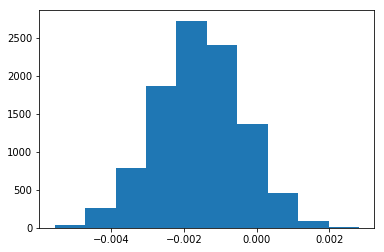

In [26]:
plt.hist(p_diffs);

>The sampling distribution is normally distributed, which is what we expect by the central limit theorem.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

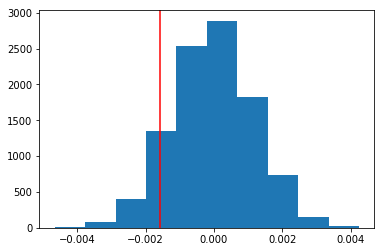

In [27]:
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals);
plt.axvline(obs_diff, color = 'red');

In [28]:
(null_vals > obs_diff).mean()

0.90569999999999995

>90.57% of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**.

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

>In part **j**, we just computed the p-value, which is the probability of observing our statistic (or one more extreme) in favor of the alternative if the null hypothesis is true.

* Here our p-value is large, we have evidence that our statistic was likely to come from the null hypothesis
* Alpha (type I error rate) is 0.05 and our p-value is 0.8992
* p-value > alpha consequently we fail to reject the null hypothesis
* **There is not a statistically significant difference between the new and old pages**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').converted.sum()
convert_new = df2.query('landing_page == "new_page"').converted.sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [30]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new,n_old]), alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

>At a 95% confidence level, the critical value is 1.96. Since the z-score does not exceed the critical value, we fail to reject the null hypothesis that the old page has a better or equal conversion rate than the new page. The p-value is really close to the one computed before. All the results agree with the findings in parts **j.** and **k.**.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>We should be performing a logistic regression, which is used to predict only two possible outcomes: conversion or no conversion.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1

In [32]:
df2= df2.join(pd.get_dummies(df2['landing_page']))

In [33]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [34]:
log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 23 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        08:54:55   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

>The p-value associated with ab_page is 0.190. 
* In part II, the null hypothesis was that the old page had a better or equal conversion rate than the old page and the alternative hypothesis was that the new page had a better conversion rate than the old page. We used hypothesis testing to determine the p-value.
* In part III, we used logistic regression to calculate the p-value. The null hypothesis was that the difference between the old and new pages is equal to 0, and the alternative hypothesis was that the difference between the old and new pages is greater or less than 0.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>Adding other factors would be a good idea to improve the reliability of the regression model, provided that the factor (which will be an independent variable) does have an impact on the dependent variable (here the conversion rate).
Without digging further, we could readily use the `timestamp` column to check whether it affects the outcome.
However, this would add complexity to the model and the new factor might not even affect the dependent variable.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [37]:
df3 = df2.merge(df_countries, on ='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US


In [38]:
df_countries['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1


In [41]:
df3['intercept'] = 1
log_mod2 = sm.Logit(df3['converted'], df3[['intercept','new_page','UK','US']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 23 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        08:55:44   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [42]:
1/np.exp(-0.0149),np.exp(0.0506),np.exp(0.0408)

(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

For every unit for new_page decrease, convert will be 1.5% more likely to happen, holding all other varible constant.

For every unit for UK increases, convert is 5.2% more to happen, holding all other varible constant.

For every unit for US increases, convert is 4.2% more to happen, holding all other varible constant.

* For each 1 unit decrease in `new_page`, conversion is 1.5% more likely to happen, holding all else constant.
* For each 1 unit increase in `UK`, conversion is 5.2% more likely to happen, holding all else constant.
* For each 1 unit increase in `US`, conversion is 4.2% more likely to happen, holding all else constant.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
df3['UK_new_page'] = df3['new_page']* df3['UK']
df3['US_new_page'] = df3['new_page']* df3['US']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,country,CA,UK,US,UK_new_page,US_new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1,US,0,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1,US,0,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0,US,0,0,1,0,0


In [45]:
logit_mod3 = sm.Logit(df3['converted'], df3[['intercept','new_page','UK_new_page','US_new_page','UK','US']])
results3 = logit_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 23 Jun 2019   Pseudo R-squ.:               3.482e-05
Time:                        09:03:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_new_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_new_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK              0.0118      0.040      0.296      0.767      -0.066       0.090
US              0.0175      0.038      0.465      0.642      -0.056       0.091
===============================================================================
"""

In [46]:
np.exp(results3.params)

intercept      0.134794
new_page       0.934776
UK_new_page    1.081428
US_new_page    1.048001
UK             1.011854
US             1.017682
dtype: float64

From the above Logit Regression Results, we can see the coefficient of intereaction variable "UK_new_page" and "US_new_page" are different from the coefficient of new_page itself. 

Also,only intercept's p-value is less than 0.05, which is statistically significant enough for converted rate. Other varable in the summary are not statistically significant. 
Additionally, Z-score for all X variables are not large enough to be significant for predicting converted rate. 

Therefore, the country a user lives is not significant on the converted rate considering the page the user land in. 



>Only the intercept p-value is less than alpha (0.05 here for a 95% confidence interval). For all the other variables, p-values are higher than 0.05, which means that they are not statistically significant. To conclude, the country of a user is not statistically significant for the conversion rate considering he landed in the new page.

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0